# Testing QSAR of Targets

In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table(f'{path}/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Picking a target.

In [14]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 0
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

Docking.

In [16]:
from dgym.envs.oracle import DockingOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    # 'exhaustiveness': 1024,
    # 'max_step': 80,
    **config_
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{dockstring_dir}/{target}',
    config=config
)

Designer.

In [17]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Generate molecules.

In [36]:
from tqdm.notebook import tqdm
import io
from contextlib import redirect_stdout
f = io.StringIO()

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck))
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

with redirect_stdout(f):
    random_molecules = []
    for _ in tqdm(range(20)): # 20

        # pick a molecule randomly from the deck
        initial_molecule = select_molecule(deck)

        # generate a few rounds of random molecules in REAL Space
        molecule = initial_molecule
        designer.reset()
        for _ in range(3): # 3
            molecule = designer.design(molecule, 1, temperature=1.0)[0]

        # generate a bunch of analogs
        molecules = designer.design(molecule, 3, temperature=0.0)

        random_molecules.extend(molecules)

  0%|          | 0/20 [00:00<?, ?it/s]

[22:34:21] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[22:34:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 14 16 19
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 14 16 19
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 14 16 19
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 9 11 13
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 9 11 13 14 15 16 17
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[22:34:23] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[22:34:24] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 20 21 25
[22:34:24] Can't kekulize mol.  Unkekulized atoms: 11 13 15 16 19 20 21
[22:34:24] Can't kekulize mol.  Unkekulized atoms: 11 13 15 16 19 20 22
[22:34:24] Can't kekulize mol.  

Get results of docking.

In [37]:
import time
import numpy as np

t = time.time()

records = []
# for max_step in [0]:
with redirect_stdout(f):

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        # 'exhaustiveness': 256,
        # 'max_step': max_step,
        **config_
    }

    # Create noiseless evaluators
    docking_oracle = DockingOracle(
        f'{name} affinity',
        receptor_path=f'{dockstring_dir}/{target}',
        config=config
    )

    for trial in tqdm(range(50)):
        scores_ = docking_oracle(random_molecules, use_cache=False)
        records_ = [
            {
                'trial': trial,
                'score': s,
                'molecule': molecule
            } for molecule, s in enumerate(scores_)
        ]
        records.extend(records_)

print(time.time() - t)
df = pd.DataFrame(records)

  0%|          | 0/50 [00:00<?, ?it/s]

[22:34:37] UFFTYPER: Unrecognized atom type: S_6+6 (21)
[22:34:37] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:34:37] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:34:56] UFFTYPER: Unrecognized atom type: S_6+6 (21)
[22:34:56] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:34:56] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:35:12] UFFTYPER: Unrecognized atom type: S_6+6 (21)
[22:35:12] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:35:12] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:35:29] UFFTYPER: Unrecognized atom type: S_6+6 (21)
[22:35:29] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:35:29] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:35:46] UFFTYPER: Unrecognized atom type: S_6+6 (21)
[22:35:46] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:35:46] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:36:03] UFFTYPER: Unrecognized atom type: S_6+6 (21)
[22:36:03] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:36:03] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[22:

827.7041597366333


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0.5, 12.44444444444443, 'Standard deviation')

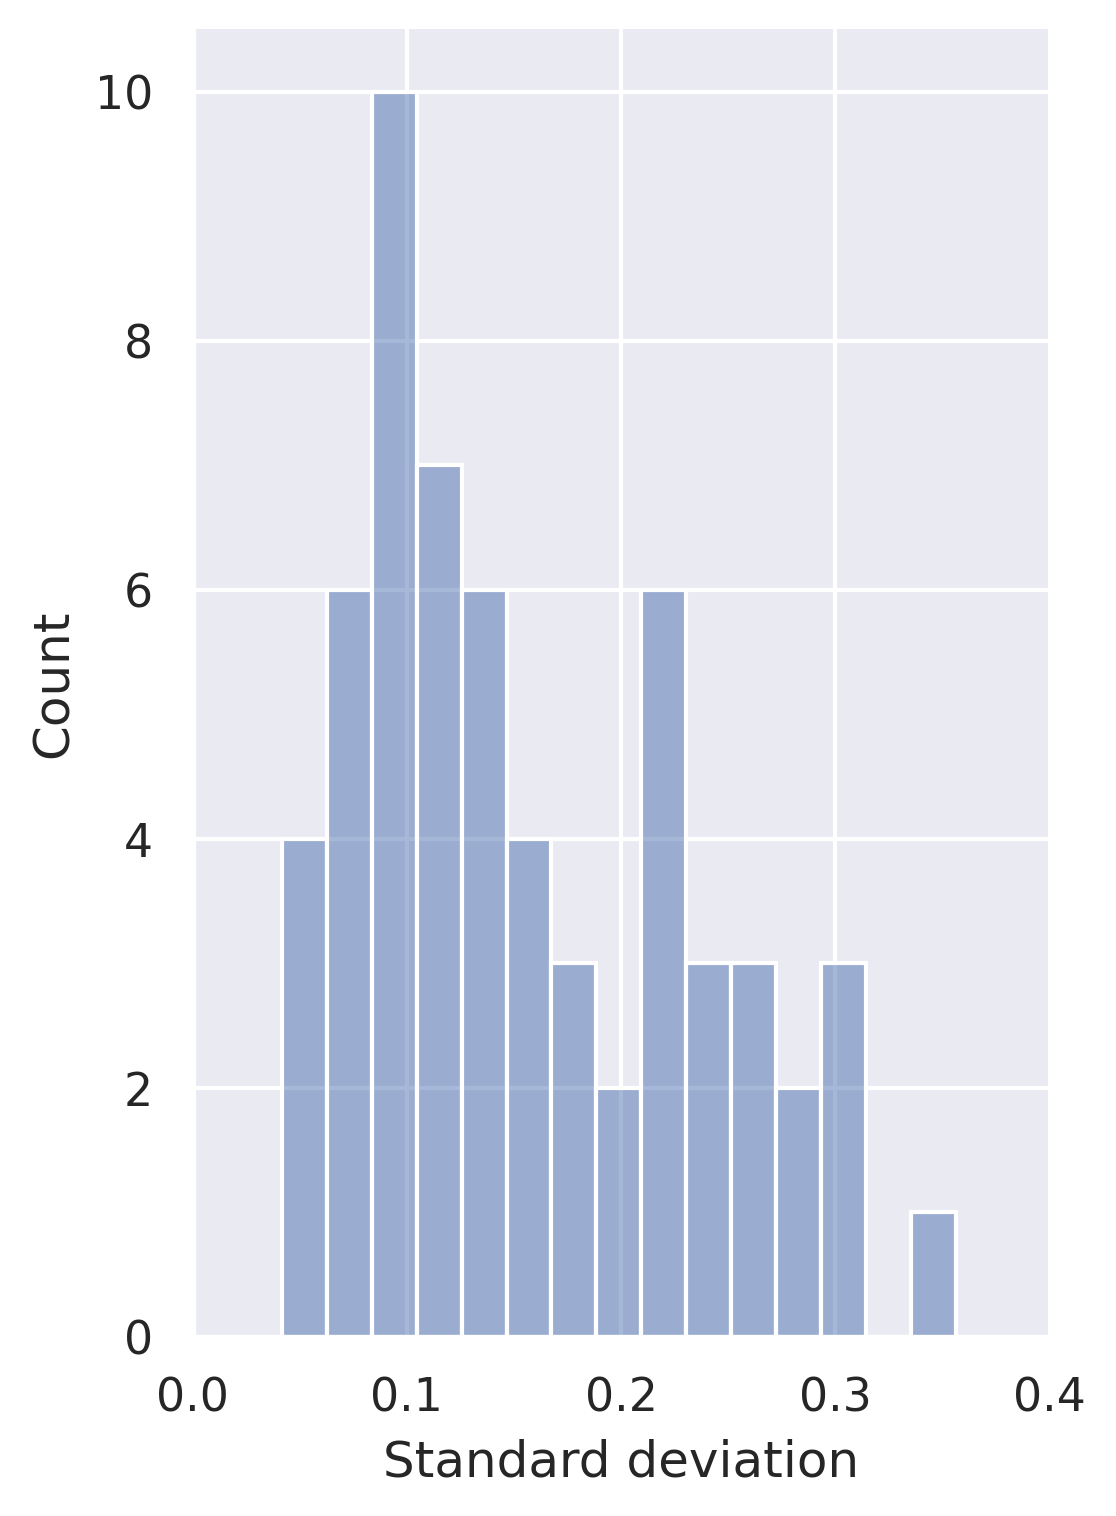

In [104]:
import seaborn as sns

sns.set()
g = sns.displot(
    df.groupby('molecule').agg({'score': 'std'}),
    aspect=0.75,
    bins=15,
    legend=False
)
g.fig.set_dpi(300)
plt.xlim(0.0, 0.4)
plt.xlabel('Standard deviation')

Text(0.5, 1.0, 'pIC50 standard deviation\nover replicate docking runs (N=20)\nfor each molecule (M=60)')

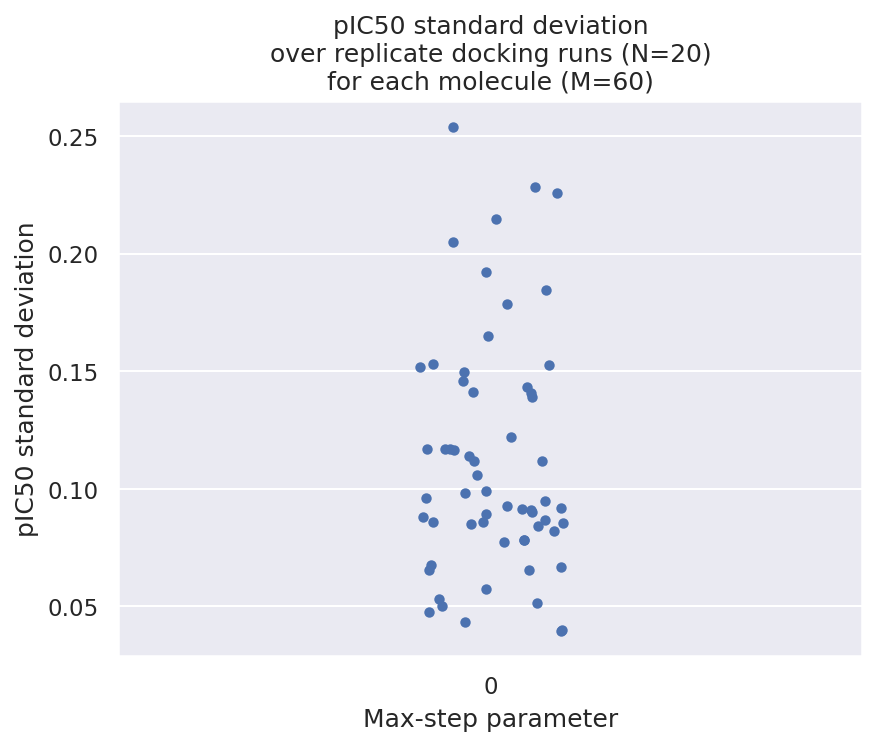

In [478]:
sns.set_theme(rc={"figure.dpi": 150})

g = sns.displot(
    (
        df.pivot_table(
            columns=['max_step'],
            index=['molecule'],
            aggfunc='std')['score']
        .stack()
        .reset_index()
    ),
    x='max_step',
    y=0,
)

plt.xlabel('Max-step parameter')
plt.ylabel('pIC50 standard deviation')
plt.title('pIC50 standard deviation\nover replicate docking runs (N=20)\nfor each molecule (M=60)')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0.5, 1.0, 'Repeat pIC50 of molecules | exhaustiveness = 256 | max_step = 40 | n = 20 | scorer = Vina')

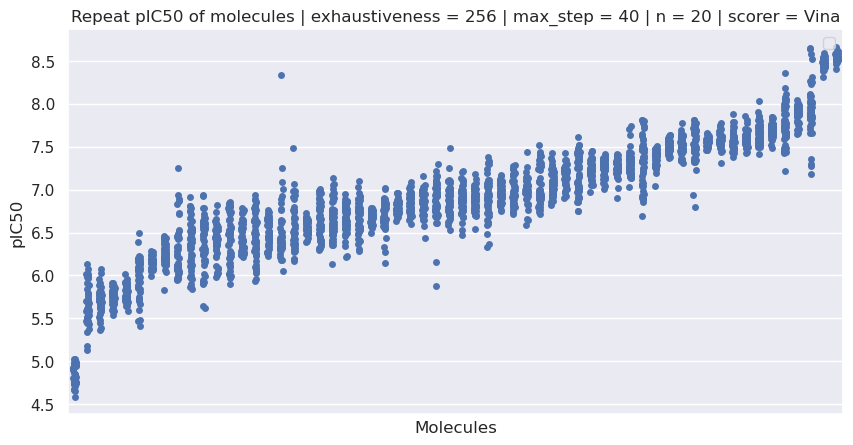

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.figure(figsize=(10, 5))

# df = (
#     pd.DataFrame(scores)
#     .stack()
#     .reset_index()
#     .set_axis(['molecule', 'trial', 'rank'], axis=1)
# )

molecules_sorted = (
    df
    .groupby('molecule')
    .agg('mean')['score']
    .sort_values(ascending=True)
)

g = sns.stripplot(
    df,
    x='molecule',
    y='score',
    order=molecules_sorted.index,
    # hue='molecule',
    # palette='colorblind'
)

plt.xticks([])
plt.legend([])
# g.axes.invert_yaxis()
# plt.ylim(3.5, 7.5)
plt.ylabel('pIC50')
plt.xlabel('Molecules')
plt.title('Repeat pIC50 of molecules | exhaustiveness = 256 | max_step = 40 | n = 20 | scorer = Vina')

Text(0.5, 1.0, 'Repeat pIC50 of molecules | exhaustiveness = 256 | max_step = 40 | n = 20 | scorer = Vina')

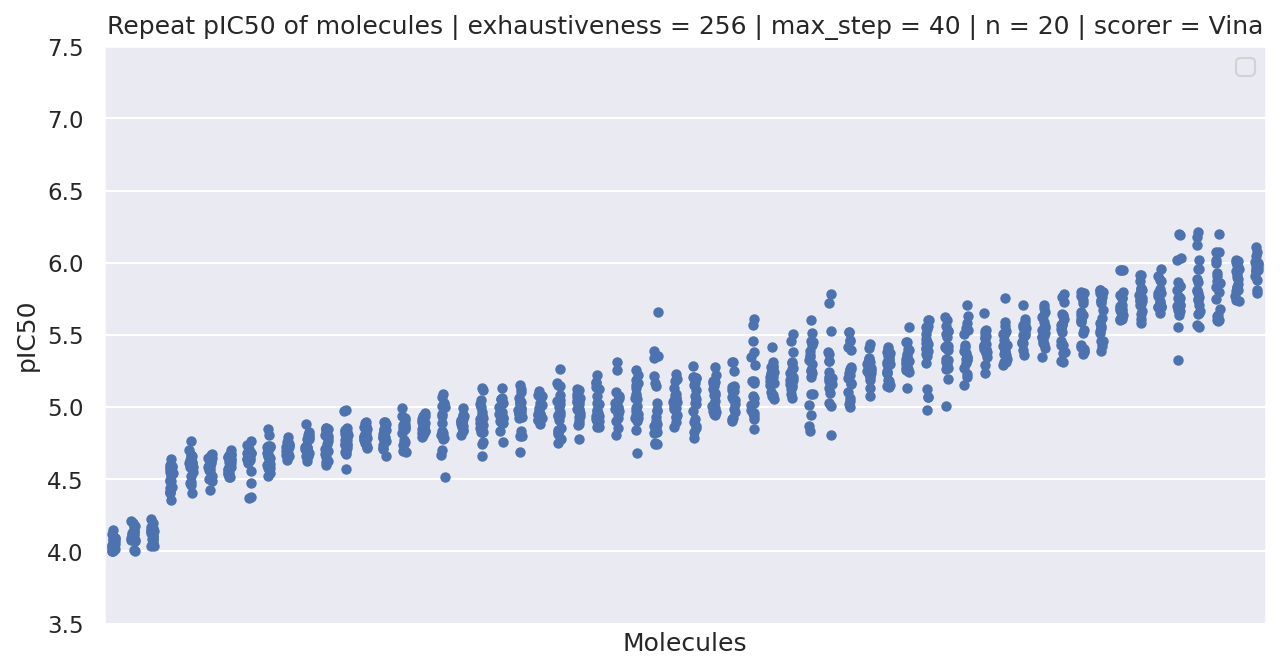

In [494]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.figure(figsize=(10, 5))

# df = (
#     pd.DataFrame(scores)
#     .stack()
#     .reset_index()
#     .set_axis(['molecule', 'trial', 'rank'], axis=1)
# )

molecules_sorted = (
    df
    .groupby('molecule')
    .agg('mean')['score']
    .sort_values(ascending=True)
)

g = sns.stripplot(
    df,
    x='molecule',
    y='score',
    order=molecules_sorted.index,
    # hue='molecule',
    # palette='colorblind'
)

plt.xticks([])
plt.legend([])
# g.axes.invert_yaxis()
plt.ylim(3.5, 7.5)
plt.ylabel('pIC50')
plt.xlabel('Molecules')
plt.title('Repeat pIC50 of molecules | exhaustiveness = 256 | max_step = 40 | n = 20 | scorer = Vina')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


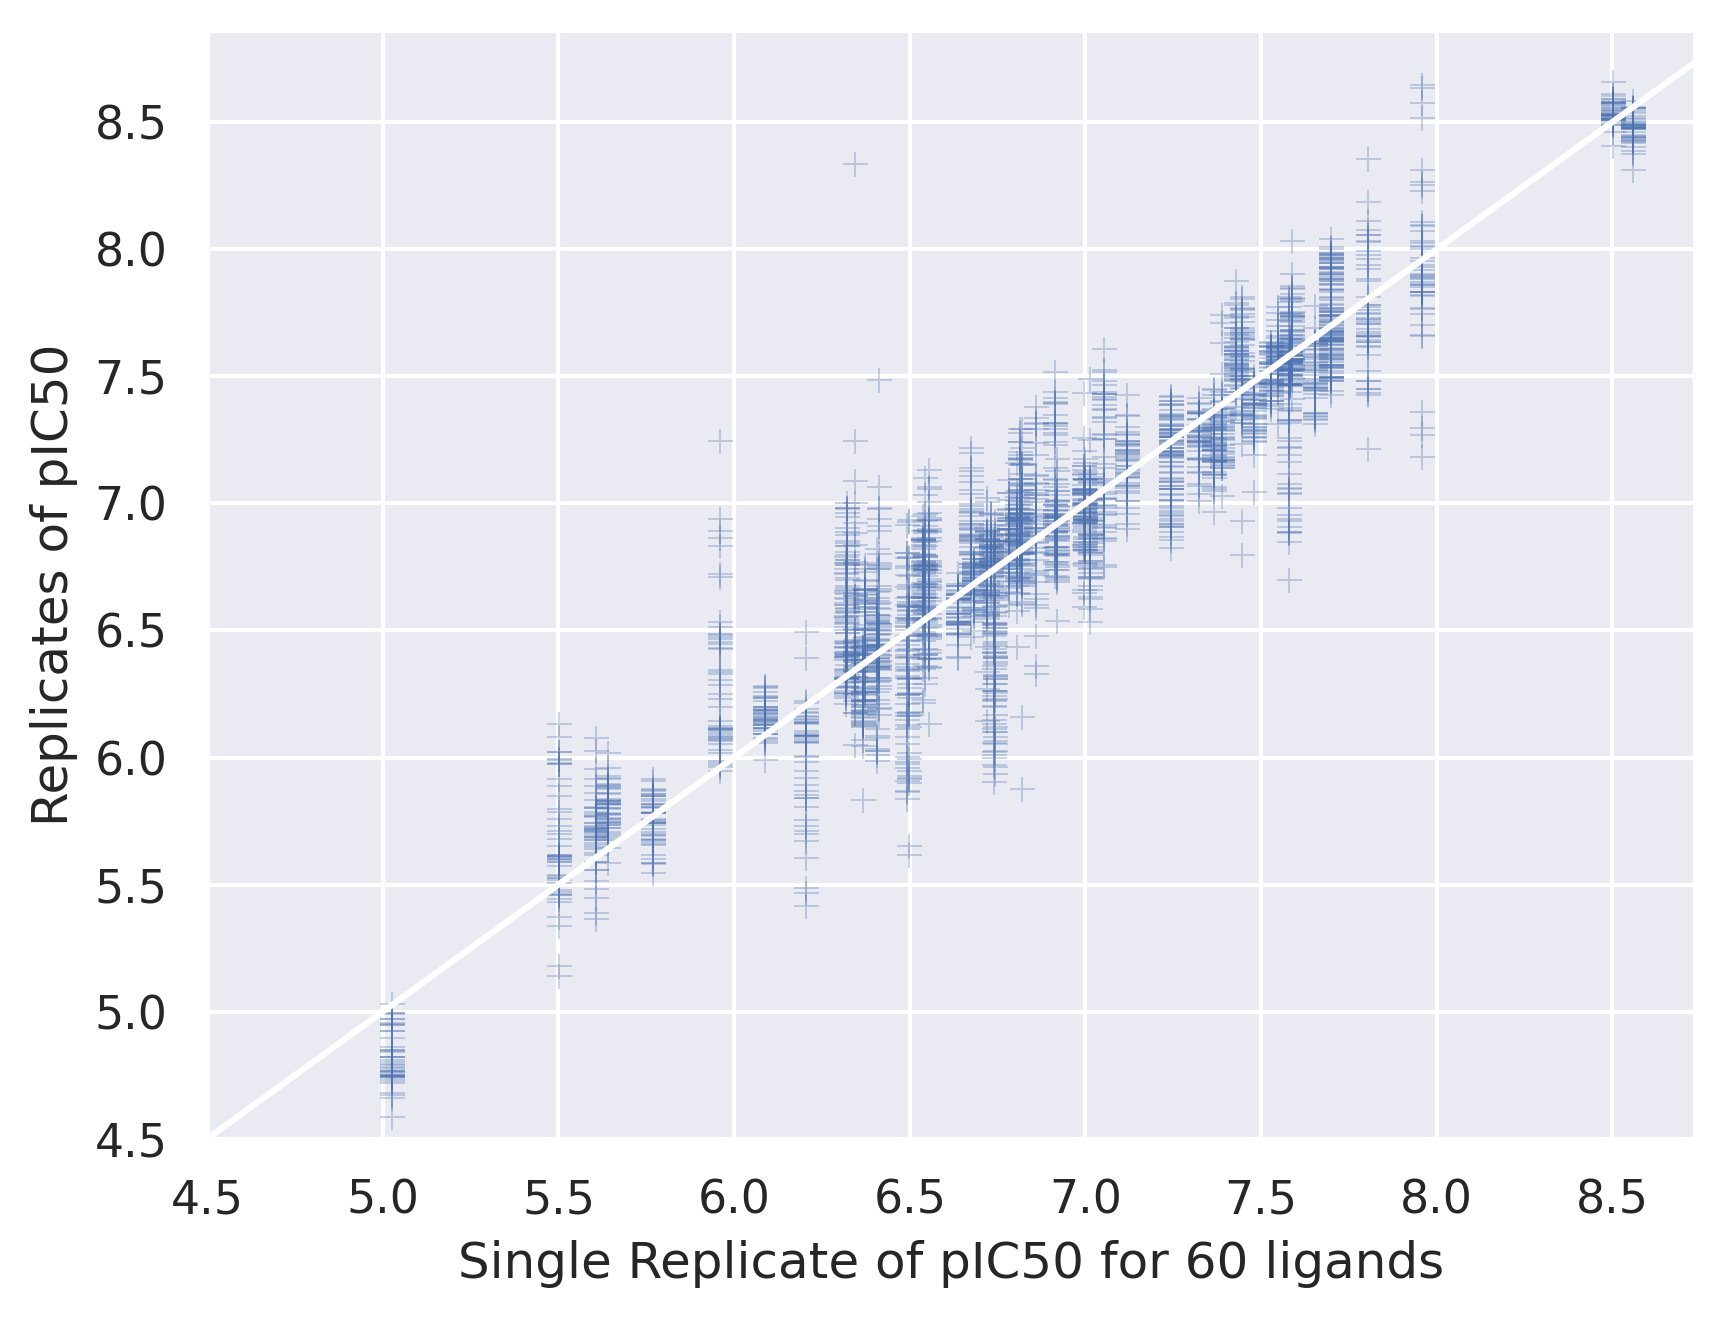

In [93]:
plt.figure(dpi=300)

sns.scatterplot(
    x=np.tile(df.query('trial == 0')['score'], len(df.trial.unique()) - 1),
    y=df.query('trial > 0')['score'],
    alpha=0.3,
    marker='+'
)
plt.xlabel('Single Replicate of pIC50 for 60 ligands')
plt.ylabel('Replicates of pIC50')
plt.xlim(4.5)
plt.ylim(4.5)

# Create a range of values for x
x = np.linspace(0, 10, 100)

# Since the line is x = y, y values will be the same as x
y = x

# Create the plot
plt.plot(x, y, linestyle='-', color='white', alpha=1.0)  # ':' indicates a dotted line

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Molecules')

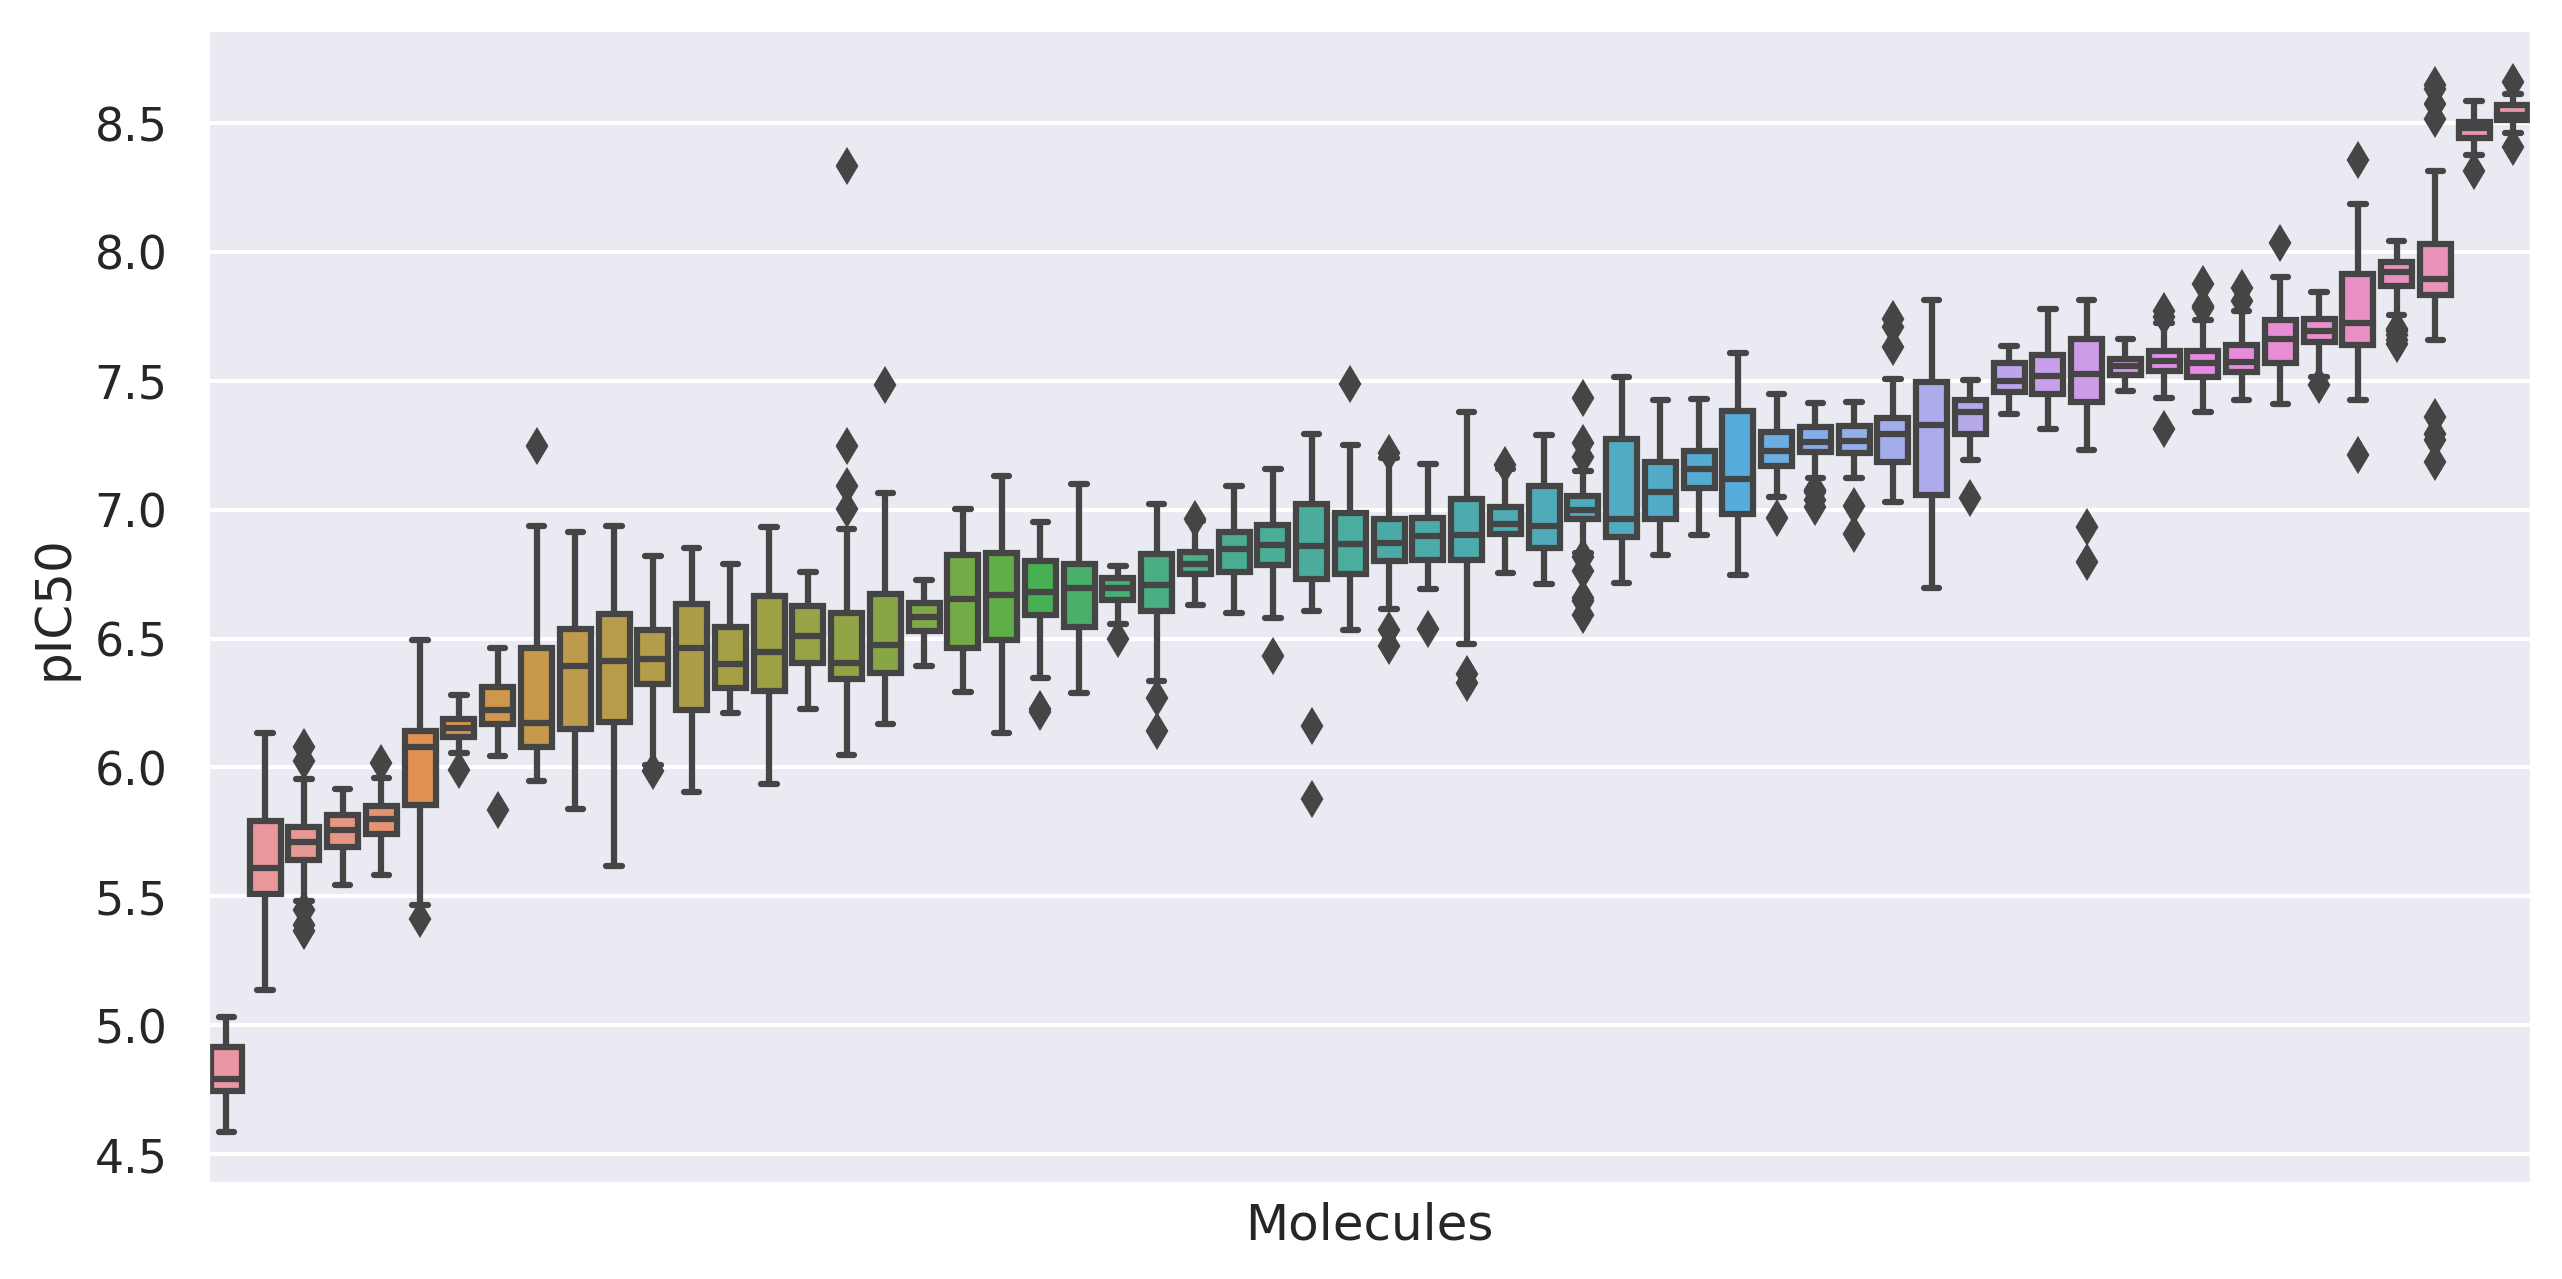

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.figure(figsize=(10, 5), dpi=300)

# df = (
#     pd.DataFrame(scores)
#     .stack()
#     .reset_index()
#     .set_axis(['molecule', 'trial', 'rank'], axis=1)
# )

molecules_sorted = (
    df
    .groupby('molecule')
    .agg('mean')['score']
    .sort_values(ascending=True)
)

g = sns.boxplot(
    df,
    x='molecule',
    y='score',
    order=molecules_sorted.index,
    # hue='molecule',
    # palette='colorblind'
)

plt.xticks([])
# plt.legend([])
# g.axes.invert_yaxis()
# plt.ylim(3.5, 7.5)
plt.ylabel('pIC50')
plt.xlabel('Molecules')
# plt.title('Repeat pIC50 of molecules | mode = fast | n = 10 | scorer = Vina | batch loop')

Text(0.5, 1.0, 'Repeat pIC50 of molecules | mode = fast | n = 10 | scorer = Vina | batch loop')

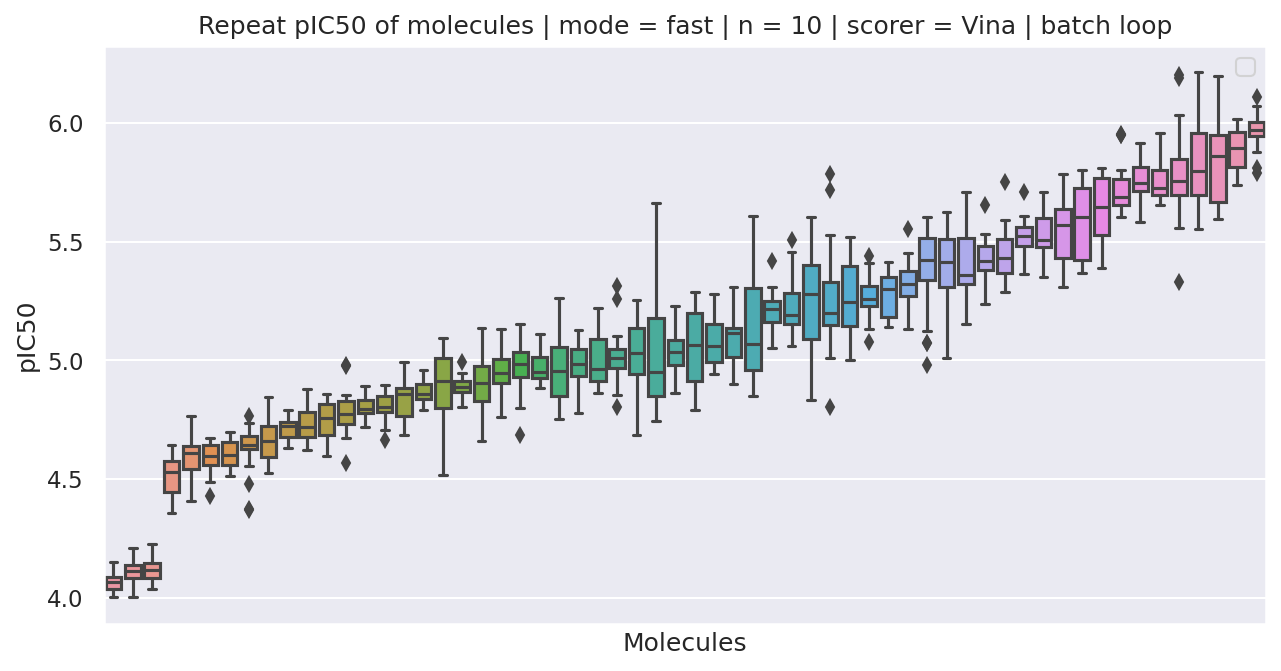

In [482]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.figure(figsize=(10, 5))

# df = (
#     pd.DataFrame(scores)
#     .stack()
#     .reset_index()
#     .set_axis(['molecule', 'trial', 'rank'], axis=1)
# )

molecules_sorted = (
    df
    .groupby('molecule')
    .agg('mean')['score']
    .sort_values(ascending=True)
)

g = sns.boxplot(
    df,
    x='molecule',
    y='score',
    order=molecules_sorted.index,
    # hue='molecule',
    # palette='colorblind'
)

plt.xticks([])
plt.legend([])
# g.axes.invert_yaxis()
# plt.ylim(3.5, 7.5)
plt.ylabel('pIC50')
plt.xlabel('Molecules')
plt.title('Repeat pIC50 of molecules | mode = fast | n = 10 | scorer = Vina | batch loop')

In [489]:
df.groupby('molecule').std()['score'].mean()

0.1116864479780691

### Manual greedy loop

In [53]:
designer.reset_cache()
best = np.argmax(docking_oracle(random_molecules))
print(np.nanmax(docking_oracle(random_molecules)))

# 1
analogs_1 = designer.design(random_molecules[best], 30)
analog_scores = docking_oracle(analogs_1)
best_1 = np.nanargmax(analog_scores)
print(np.nanmax(analog_scores))

# 2
analogs_2 = designer.design(analogs_1[best_1], 30)
analog_scores = docking_oracle(analogs_2)
best_2 = np.nanargmax(analog_scores)
print(np.nanmax(analog_scores))

# 3
analogs_3 = designer.design(analogs_2[best_2], 30)
analog_scores = docking_oracle(analogs_3)
best_3 = np.nanargmax(analog_scores)
print(np.nanmax(analog_scores))

5.916298691714425
5.916298691714425
6.03296144552947
5.924749057050759


In [54]:
docking_oracle(analogs_2[best_2])

[6.03296144552947]

In [55]:
docking_oracle(analogs_3[best_3], use_cache=False)

[5.376921596645969]

In [43]:
t = time.time()

[
    print(docking_oracle([analogs_3[best_3]], use_cache=False))
    for _ in range(10)
]

print(t - time.time())

[6.029620151236963]
[6.013843137074134]
[5.939064735729019]
[5.870923017045347]
[6.062938524934357]
[5.863198941805746]
[5.9280056382471855]
[5.9115060885423425]
[6.034469157876453]
[5.811323554616513]
-25.71050786972046


In [56]:
import time

t = time.time()
result = docking_oracle([analogs_3[best_3]]*10, use_cache=False)
print(t - time.time())

-5.719982624053955


In [58]:
result

[5.3883165955549694,
 5.542180660804189,
 5.4465941980381745,
 5.377179782100717,
 5.3686489631251195,
 5.293940059565093,
 5.435228775437465,
 5.376902070970315,
 5.396612958563865,
 5.2582243771940025]

### Compare pairwise fingerprints and affinity

In [39]:
import chemfp

self = designer.generator

fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in random_molecules
]

queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries=queries,
    targets=queries,
    threshold=0.0,
    include_lower_triangle=False,
)

similarity = results.to_pandas()
similarity_matrix = results.to_csr().A

queries:   0%|                                                                                 | 0/60 [00:00<?…

Get affinity score differences.

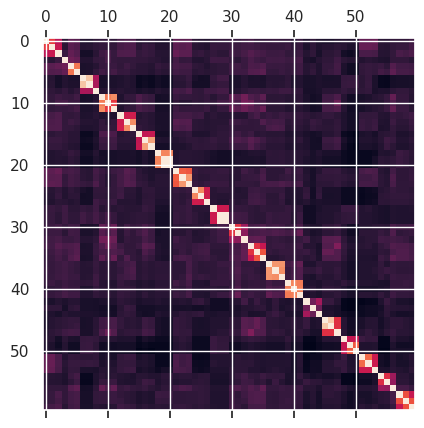

In [40]:
import numpy as np
from sklearn.metrics.pairwise import nan_euclidean_distances

scores = docking_oracle(random_molecules)

# Convert the list of floats to a 2D numpy array with one column
float_array = np.array(scores).reshape(-1, 1)

# Calculate pairwise distances using the default metric (Euclidean)
distances = nan_euclidean_distances(float_array)

import matplotlib.pyplot as plt
plt.matshow(similarity_matrix)

### Look at inter- vs. intra-cluster variation

In [41]:
import numpy as np

chunks = np.array_split(random_molecules, 20)
cluster_stds = [np.nanstd(docking_oracle(chunk)) for chunk in chunks]
mean_cluster_std = np.nanmean(cluster_stds)
mean_std = np.nanstd(scores)
print('Within Cluster:', mean_cluster_std,
      '\nBetween Cluster:', mean_std)

Within Cluster: 0.15669793307819938 
Between Cluster: 0.5379443737090935


In [42]:
np.nanquantile(abs(distances).ravel(), 0.9)

1.2875387893952202

Text(0.5, 1.0, 'Correlation of Docking and Fingerprint Similarity')

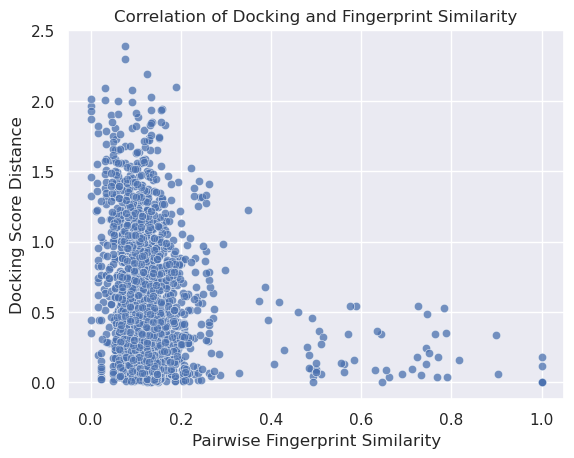

In [43]:
sns.set()
g = sns.scatterplot(
    x=similarity_matrix.ravel(),
    y=abs(distances).ravel(),
    alpha=0.5
)

plt.xlabel('Pairwise Fingerprint Similarity')
plt.ylabel('Docking Score Distance')
plt.title('Correlation of Docking and Fingerprint Similarity')

Seeing if being similar to high affinity molecules predicts high affinity.

In [44]:
best = np.argsort(scores)[-10:]
best_molecules = dg.collection.Collection(random_molecules)[best]

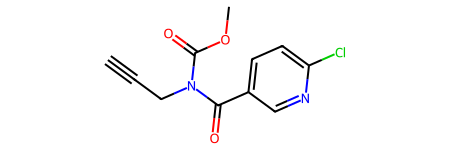

In [45]:
random_molecules[4]

In [59]:
import chemfp

self = designer.generator

fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in best_molecules
]

best_queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries=best_queries,
    targets=queries,
    k=5,
    include_lower_triangle=False,
)

queries:   0%|                                                                                 | 0/10 [00:00<?…

In [54]:
np.nanargmax(docking_oracle(random_molecules))

32

In [60]:
# mols = results.to_pandas()['target_id'].tolist()
nearest_scores = [
    scores[i]
    for index in results.iter_indices()
    for i in index
    if i not in best
]

np.nanmean(nearest_scores)

5.33953094785155